## Load libraries and setup env

In [1]:
'''
Start jupter notebook from project home directory `/fashion-mnist-assignment`
Then look up this notebook in folder `my_code` and the paths and directories should all work fine
'''

%cd ..

import cv2
import scipy
import numpy as np
from PIL import Image
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
from my_code import helpers
from my_code import models

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, regularizers, backend
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import InputLayer, Lambda, LeakyReLU, ReLU, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, MaxPool2D, AveragePooling2D, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from utils import mnist_reader
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/kuba/repos/fashion-mnist-assignment


## Load data for visualization only

Proper 3 subset split for training is done in `helper.py`

Train 60000, Test 10000
Ankle boot 



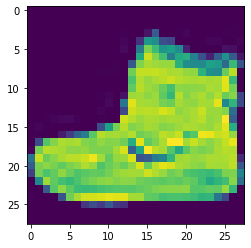

Pullover 



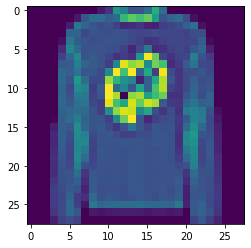

In [2]:
IMG_SIZE = 28
NUM_CLASSES = 10
SEED = 2019
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

print("Train {:}, Test {:}".format(X_train.shape[0], X_test.shape[0]))

# Reshape data to have channel dimension
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 1)

# One hot encode the data
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES, dtype='float32')
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES, dtype='float32')

# Plot sample data
img = X_train[0,:,:]
plt.figure()
plt.imshow(img.squeeze())
print(classes[y_train[0]],'\n')
plt.show()

img = X_train[123,:,:]
plt.figure()
plt.imshow(img.squeeze())
print(classes[y_train[123]],'\n')
plt.show()

## Model v1

In [0]:
# Let's train first model
params = {
          'conv':32,
          'epochs': 30,
          'augment': False,
          'batch_size': 64,
          'dense': 64,
          'optimizer': Adam,
          'lr': 1e-4,
          'patience': 3,
          'build_fn': models.build_model_v1,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
}

evals = 1
trials = Trials()
best = fmin(helpers.hyper_tuning_fn, params, algo=tpe.suggest, max_evals=evals, trials=trials)
print('Best: ',best)                  


Params testing: 
{'augment': False, 'batch_size': 64, 'build_fn': <function build_model_v1 at 0x7f4b7cc10a60>, 'conv': 32, 'dense': 64, 'epochs': 30, 'lr': 0.0001, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'patience': 3}
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_327 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_329 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 14, 14, 64)        36928     
_

### Data augmentation:
Try the same model but introduce data augmentation
- `rescale=1./255`
- `width_shift_range=3`
- `height_shift_range=3`
- `horizontal_flip=True`
- `cval=0`
- `fill_mode='constant'`

Values have been selected carefully as the image size is small with rather small paddings. I also tested 

- `rotation_range=5`
- `shear_range=0.1`
- `zoom_range=(0.9, 1.1)

But all of them prevented me from getting above 93% accuracy.

### Possible explanation:
- small padding - transformation made the edges of the object go outside of the image
- images are very pixelated and rotation & shear just distorted them too much, even with small rotation

In [4]:
# Added augmentation

params = {
          'conv':32,
          'epochs': 30,
          'augment': True,
          'batch_size': 64,
          'dense': 64,
          'optimizer': Adam,
          'lr': 1e-4,
          'patience': 10,
          'build_fn': models.build_model_v1,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
}

evals = 1
trials = Trials()
best = fmin(helpers.hyper_tuning_fn, params, algo=tpe.suggest, max_evals=evals, trials=trials)
print('Best: ',best)                  


Passed parameters: 
{'augment': True, 'batch_size': 64, 'build_fn': <function build_model_v1 at 0x7f95b5de0a60>, 'conv': 32, 'data_path': 'data/fashion', 'dense': 64, 'epochs': 30, 'image_size': 28, 'lr': 0.0001, 'num_classes': 10, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'patience': 10}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________

Even such simple augmentation helped a bit as could be expected.


However, it made the process more difficult, as after the same amount of epochs as before, the performance is much lower. 


Now, we see that the model trains well, but doesn't quite reach the desired performance. 


Afterall, it's a lightweight model - compared to for example common MobileNet (4.2M params with88 layers)


## Model v2

Let's add some extra capacity to the model 
- more filters in 2 last conv layers
- extra dense layer
- more neurons in dense layers


In [0]:
params = {
          'conv':32,
          'epochs': 50,
          'augment': True,
          'batch_size': 64,
          'dense': 128,
          'optimizer': Adam,
          'loss': 'categorical_crossentropy',
          'lr': 3e-4,
          'patience': 10,
          'build_fn': models.build_model_v2,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
}
            
                        
evals = 1
trials = Trials()
best = fmin(helpers.hyper_tuning_fn, params, algo=tpe.suggest, max_evals=evals, trials=trials)
print('Best: ',best)  

Params testing: 
{'augment': True, 'batch_size': 64, 'build_fn': <function build_model_v2 at 0x7f6b4f008d08>, 'conv': 32, 'dense': 128, 'epochs': 50, 'loss': 'categorical_crossentropy', 'lr': 0.0003, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'patience': 10}
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (

It's moving forward - but the training is still quite slow with some strong overfitting. 

Though, it's disappoint that the test accuracy is actually quite a bit lower than the validation

`781/781 - 24s - loss: 0.1653 - acc: 0.9395 - val_loss: 0.1950 - val_acc: 0.9333`

`Accuracy test: 0.926`

<br><br>
#### Change
Add more neurons & filters and further increase learning rate

In [0]:
params = {
          'conv':64,
          'epochs': 50,
          'augment': True,
          'batch_size': 64,
          'dense': 256,
          'optimizer': Adam,
          'loss': 'categorical_crossentropy',
          'lr': 3e-4,
          'patience': 10,
          'build_fn': models.build_model_v2,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
}
            
                        
evals = 1
trials = Trials()
best = fmin(helpers.hyper_tuning_fn, params, algo=tpe.suggest, max_evals=evals, trials=trials)
print('Best: ',best)   

Params testing: 
{'augment': True, 'batch_size': 64, 'build_fn': <function build_model_v2 at 0x7f6b4f008d08>, 'conv': 64, 'dense': 256, 'epochs': 50, 'loss': 'categorical_crossentropy', 'lr': 0.0003, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'patience': 10}
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_81 (Conv2D)           (

<b>The overfitting starts around epoch 20. </b>

Although, both the valdation loss and accuracy happen to improve after that point, generally, it doesn't seem a great idea to train beyond that point.  

Though, after 48 epochs (stopped after not improving `val_acc` for 10 epoch) I arrived at

`781/781 - 28s - loss: 0.1138 - acc: 0.9574 - `val_loss: 0.2191 - val_acc: 0.9334

`Accuracy test: 0.931`

<br><br>

#### Change
Based on the above, train the final model using 

`epochs=23`

`conv=64`

`dense=256`

`lr=3e-4`

`conv=64`


In [0]:
params = {
          'conv':64,
          'epochs': 23,
          'augment': True,
          'batch_size': 64,
          'dense': 256,
          'optimizer': Adam,
          'loss': 'categorical_crossentropy',
          'lr': 3e-4,
          'build_fn': models.build_model_v2,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
} 
                        
hist, model = helpers.final_training_fn(params)

Final training:  {'conv': 64, 'epochs': 23, 'augment': True, 'batch_size': 64, 'dense': 256, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'loss': 'categorical_crossentropy', 'lr': 0.0003, 'build_fn': <function build_model_v2 at 0x7f67cc459510>}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
__________________________________

<b>
Already small overfitting happen, but the results were much worse than previously. 
</b>

### Inspect the activations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


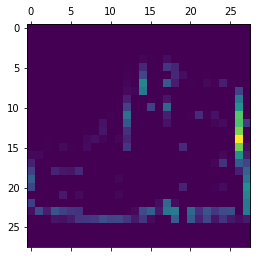

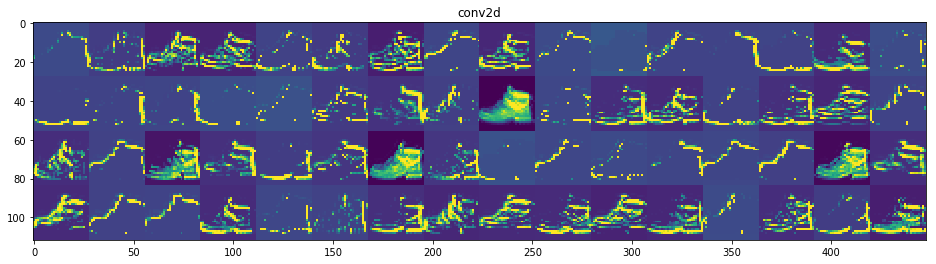

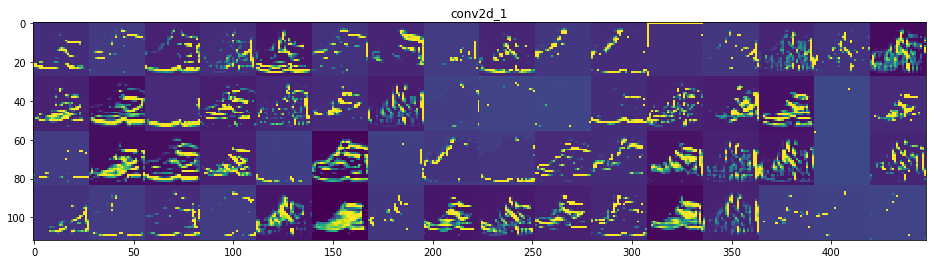

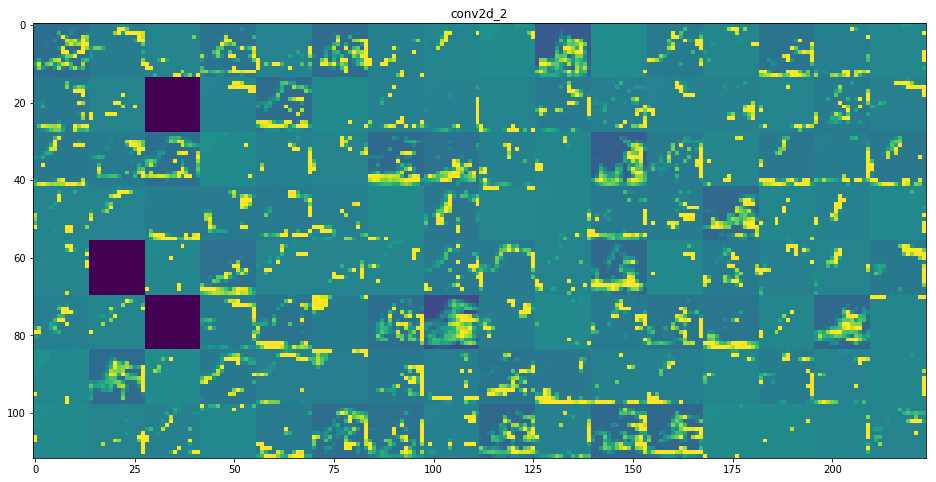

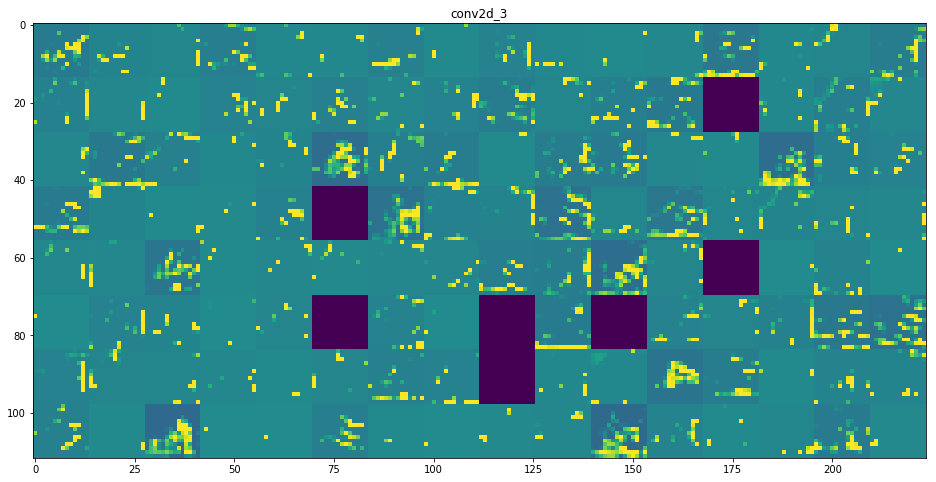

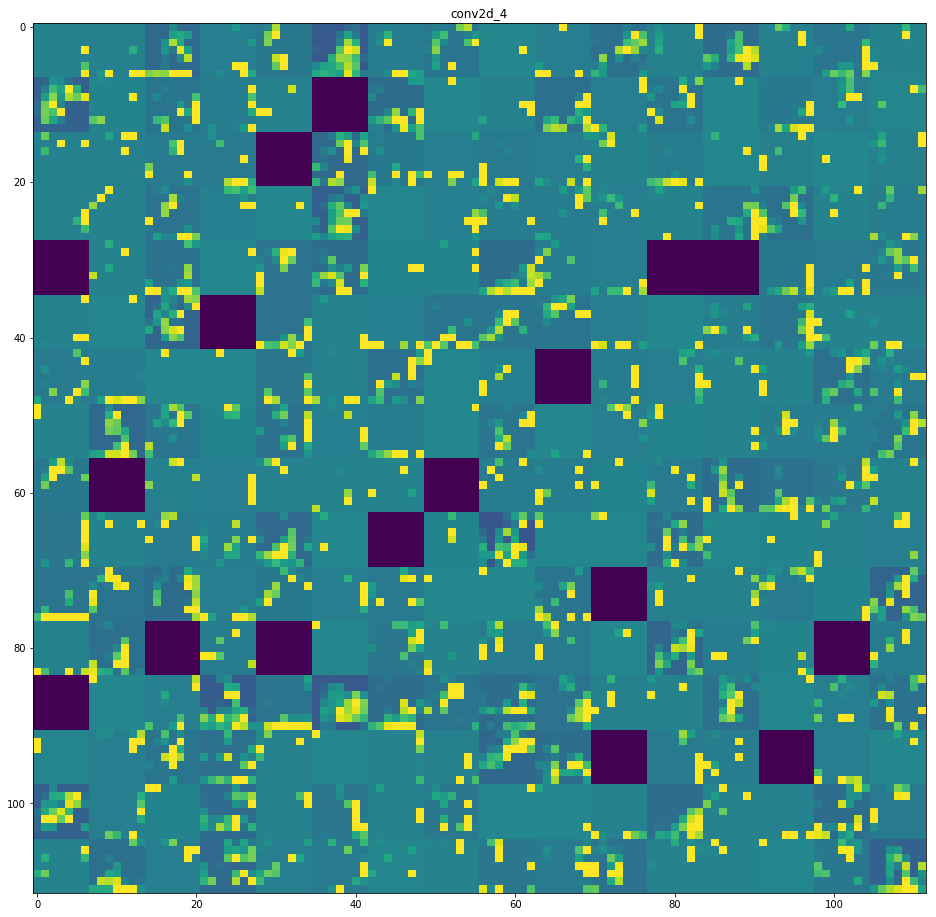

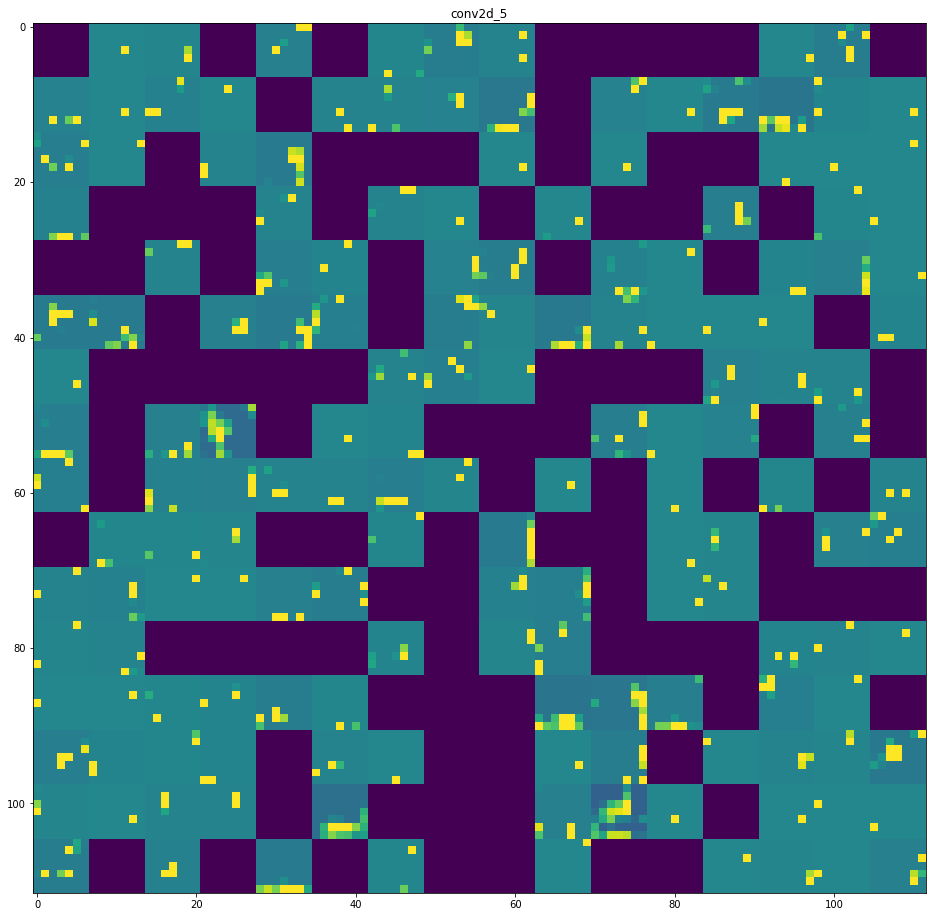

In [0]:
# extracts the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers]

# creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(img.reshape(1,28,28,1))

# activation of the 1st convolution layer
first_layer_activation = activations[0]

# display the 1st channel of the activation of the 1st layer of the original model
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

cv2_imshow(img.squeeze())

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv') or layer_name.startswith('res'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

Black activations correspond to dead neurons - common problem caused by relu - this is caused by too high gradients, which in turn might be results of bad initialization or too high learning rate. 


## Model v3

Basically: if the weights always lead to negative value (input to ReLU), ReLU will output 0 `max(0,x)`, the gradients will also be 0, thus no update and stuck at that state.

Let's swap `ReLU` it with `LeakyReLU` 

In [0]:
params = {
          'conv':64,
          'epochs': 25,
          'augment': True,
          'batch_size': 64,
          'dense': 256,
          'optimizer': Adam,
          'loss': 'categorical_crossentropy',
          'lr': 3e-4,
          'build_fn': models.build_model_v3,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
} 
            
                        
hist, model = helpers.final_training_fn(params)

Final training:  {'conv': 64, 'epochs': 25, 'augment': True, 'batch_size': 64, 'dense': 256, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'loss': 'categorical_crossentropy', 'lr': 0.0003, 'build_fn': <function build_model_v3 at 0x7f6887faa9d8>}
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)

Not really any change in the performance

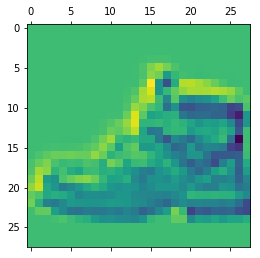

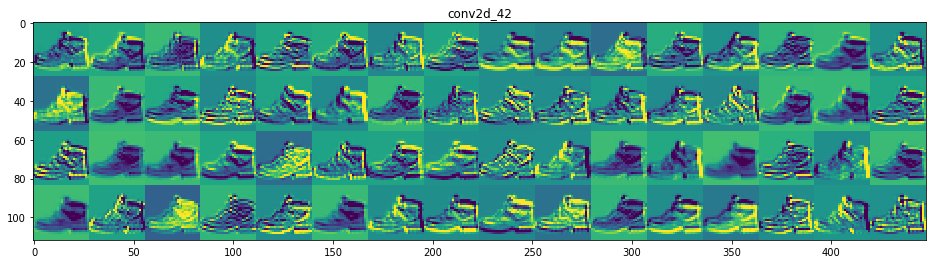

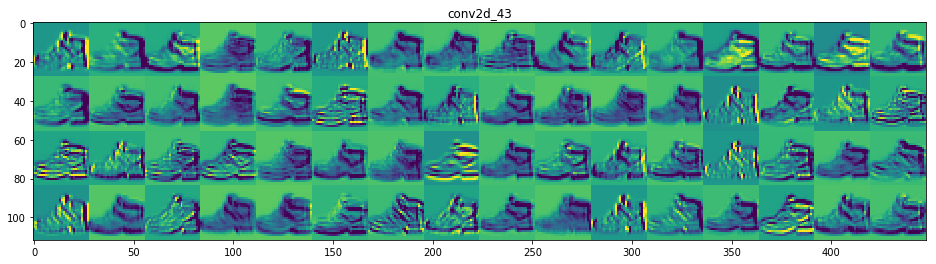

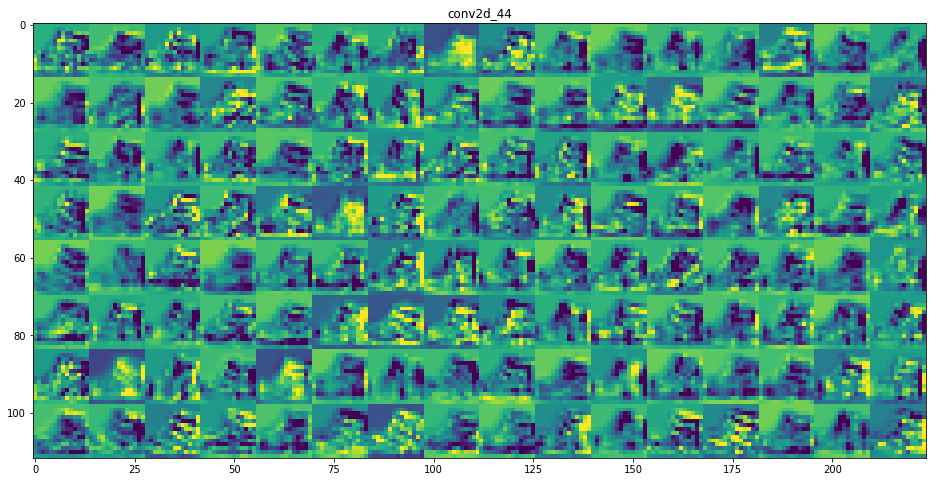

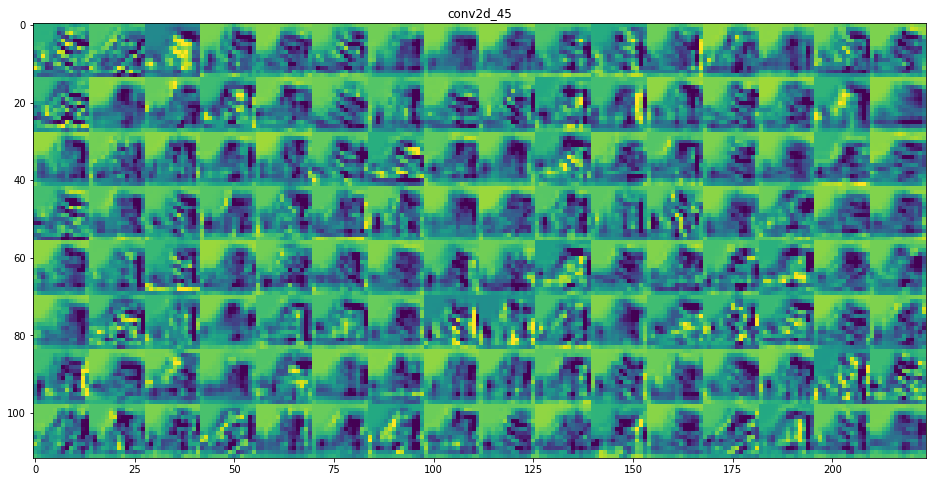

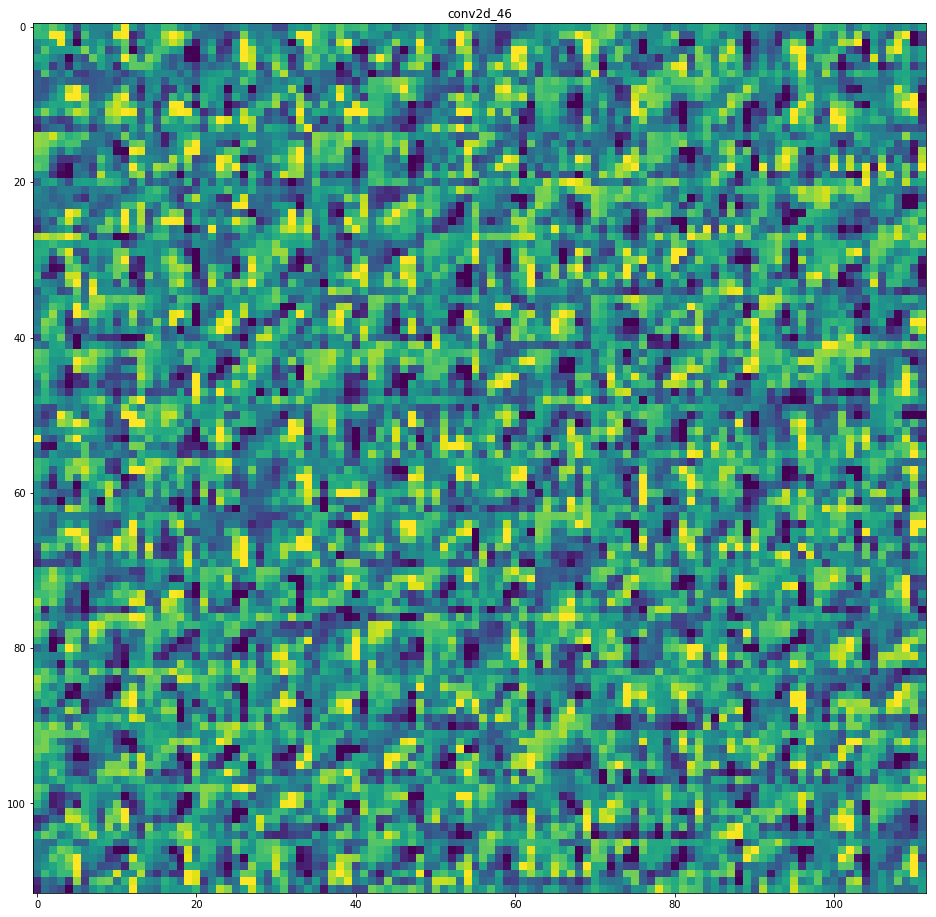

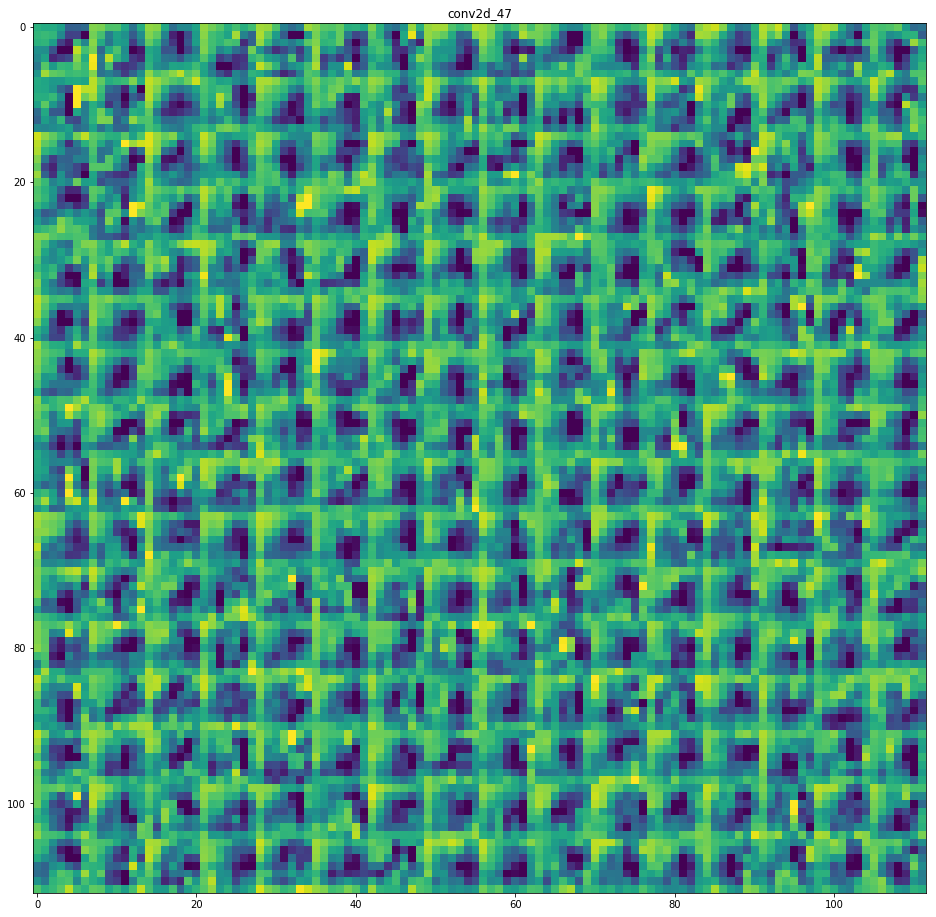

In [0]:
# extracts the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers]

# creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(img.reshape(1,28,28,1))

# activation of the 1st convolution layer
first_layer_activation = activations[0]

# display the 1st channel of the activation of the 1st layer of the original model
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

cv2_imshow(img.squeeze())

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv') or layer_name.startswith('res'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Model v4

Basically more regularization. Please check `models.py` for details

After a bit more testing, I couldn't get beyond certain point, which was around 93% accuracy for test dataset. I tweaked and tuned the hyperaparameter, architecture - number of layers, regularization etc., and there were no major changes. 

In [0]:
params = {
          'conv':64,
          'epochs': 50,
          'augment': True,
          'batch_size': 64,
          'dense': 512,
          'optimizer': Adam,
          'loss': 'categorical_crossentropy',
          'lr': 1e-4,
          'patience': 10,
          'build_fn': models.build_model_v4,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
} 

evals = 1
trials = Trials()
best = fmin(helpers.hyper_tuning_fn, params, algo=tpe.suggest, max_evals=evals, trials=trials)
print('Best: ',best)  

Params testing: 
{'augment': True, 'batch_size': 64, 'build_fn': <function build_model_v4 at 0x7f67c2af3048>, 'conv': 64, 'dense': 512, 'epochs': 50, 'loss': 'categorical_crossentropy', 'lr': 0.0001, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'patience': 10}
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (N

### Model v5

I tried my own custom model, which got me to around 93.5%, when trained for similar number of epochs than before. 

Then I tried going crazy, and not caring about overfitting, to see what's gonna happen.

In [0]:
# Let's train first model
params = {
          'conv':64,
          'epochs': 100,
          'augment': True,
          'batch_size': 512,
          'dense': 512,
          'optimizer': Adam,
          'lr': 3e-4,
          'reg_l2': 1e-5,
          'patience': 20,
          'build_fn': models.build_model_v5,
          'num_classes': NUM_CLASSES,
          'image_size': IMG_SIZE,
          'data_path': 'data/fashion',
          'model': 'v5'
}

for i in range(5):
  params['iter'] = i
  model = helpers.train_random_splits_fn(params)

Params testing:  {'conv': 64, 'epochs': 100, 'augment': True, 'dense': 512, 'batch_size': 512, 'lr': 0.0003, 'patience': 20, 'reg_l2': 1e-05, 'build_fn': <function build_model_v5 at 0x7f210dd17840>, 'model': 'v5_2', 'iter': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 128)       0         
_________________________

## Load trained models and evaluate them on thest dataset

In [4]:
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 1)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES, dtype='float32')

test_generator_args = dict(
    data_format = 'channels_last',
    rescale=1./255,
)

test_datagen = ImageDataGenerator(**test_generator_args)
test_datagen.fit(X_test)

test_generator = test_datagen.flow(
    X_test, 
    y_test_encoded, 
    batch_size=250,
    shuffle=False
)

model_name = 'v5'

accuracies = []
for i in range(5):
    model = tf.keras.models.load_model('models/model_{:}_{:}.h5'.format(model_name,i))

    result = model.evaluate_generator(test_generator)
    accuracies.append(result[1])
    print("Model {:} accuracy: {:.4f}".format(i,result[1]))
    
print("\nMean accuracy {:.4f}".format(np.mean(accuracies)))

Model 0 accuracy: 0.9398
Model 1 accuracy: 0.9419
Model 2 accuracy: 0.9431
Model 3 accuracy: 0.9407
Model 4 accuracy: 0.9457

Mean accuracy 0.9422


## Model ensemble

In [28]:
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 1)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES, dtype='float32')

test_generator_args = dict(
    data_format = 'channels_last',
    rescale=1./255,
)

test_datagen = ImageDataGenerator(**test_generator_args)
test_datagen.fit(X_test)

batch_size = 200

test_generator = test_datagen.flow(
    X_test, 
    y_test_encoded, 
    batch_size=batch_size,
    shuffle=False
)

model_name = 'v5'
loaded_models = []
num_iters = len(test_generator)

# Load 5 trained models
for i in range(5):
    loaded_models.append(tf.keras.models.load_model('models/model_{:}_{:}.h5'.format(model_name,i)))
    print("Model {:} has been loaded".format(i))

preds  = np.empty((0,))
y_true = np.empty((0,))

# Iterate over the generator manually
for i,(x,y_batch) in enumerate(test_generator):
    print("Batch {:} out of {:}".format(i,num_iters))
    preds_batch = np.zeros((batch_size,NUM_CLASSES))
    for j in range(5):
        preds_batch += np.array(loaded_models[j].predict(x))
    
    preds  = np.hstack((preds, np.argmax(preds_batch,axis=-1)))
    y_true = np.hstack((y_true, np.argmax(y_batch,axis=-1)))
    
    # stop once iterated over all examples
    if (i+1) >= num_iters:
        break

Model 0 has been loaded
Model 1 has been loaded
Model 2 has been loaded
Model 3 has been loaded
Model 4 has been loaded
Batch 1 out of 50
Batch 2 out of 50
Batch 3 out of 50
Batch 4 out of 50
Batch 5 out of 50
Batch 6 out of 50
Batch 7 out of 50
Batch 8 out of 50
Batch 9 out of 50
Batch 10 out of 50
Batch 11 out of 50
Batch 12 out of 50
Batch 13 out of 50
Batch 14 out of 50
Batch 15 out of 50
Batch 16 out of 50
Batch 17 out of 50
Batch 18 out of 50
Batch 19 out of 50
Batch 20 out of 50
Batch 21 out of 50
Batch 22 out of 50
Batch 23 out of 50
Batch 24 out of 50
Batch 25 out of 50
Batch 26 out of 50
Batch 27 out of 50
Batch 28 out of 50
Batch 29 out of 50
Batch 30 out of 50
Batch 31 out of 50
Batch 32 out of 50
Batch 33 out of 50
Batch 34 out of 50
Batch 35 out of 50
Batch 36 out of 50
Batch 37 out of 50
Batch 38 out of 50
Batch 39 out of 50
Batch 40 out of 50
Batch 41 out of 50
Batch 42 out of 50
Batch 43 out of 50
Batch 44 out of 50
Batch 45 out of 50
Batch 46 out of 50
Batch 47 out of

In [49]:
acc = np.mean(preds==y_true)
print("Test accuracy {:.4f}\n".format(acc))

print(confusion_matrix(y_true, preds))

Test accuracy 0.9486

[[911   1  18   8   0   1  56   0   5   0]
 [  0 994   0   5   0   0   0   0   1   0]
 [ 17   1 926   8  20   0  28   0   0   0]
 [  9   2   6 952  15   0  15   0   1   0]
 [  0   1  16  10 941   0  32   0   0   0]
 [  0   0   0   0   0 989   0   8   0   3]
 [ 81   0  33  14  41   0 829   0   2   0]
 [  0   0   0   0   0   3   0 985   0  12]
 [  0   0   0   2   0   0   0   0 998   0]
 [  0   0   0   0   0   6   0  33   0 961]]


## Finally! 

I got to <b>94.22%</b>, which was an average over 5 experiments using different random data splits.

Since I already got 5 trained models, I thought why not combine them. So I built simple ensemble, based on voting and it worked out. I got <b>94.86%</b> accuracy on the test dataset.

I tried some other architecutres:
- bottleneck ResNet (like ResNet50) (model v6)
- simple ResNet (like ResNet18) (model_v7)

but they didn't beat that score. 

<br><br>

Idea from paper on residual netowrks

https://arxiv.org/pdf/1512.03385.pdf

https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cc5d0adf648e

Bottleneck architecture is supposed to force the network to find better representation of the data.

#### Bottleneck basic idea:
Inside each bottleneck residual module, it attempts to comprese the data into smaller dimensional representation, which is afterward restored to previous size.


#### Why it didn't help?
Residual connections are particularly useful in case of deep neural network. For problem at hand, very deep structures were not needed, and my networks usually have around 6 convolutional layers and 2 or 3 dense onces. 